# iLykei Lecture Series 

# Machine Learning

# Decision Trees

# Workshop 3    

## Y.Balasanov, L.Nazarov &copy; iLykei 2017-22


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from numpy.random import normal,random,binomial,choice,seed
from scipy.stats import norm
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import seaborn as sns

import pydotplus
from IPython.display import Image
from io import StringIO  

We will also use function *plot_tree* for visualisation.

In [2]:
def plot_tree(estimator,feature_names):
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data,feature_names=feature_names,
                   rounded=True,filled=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return Image(graph.create_png()) 

Introduction
============

Classification problem
----------------------

In machine learning and statistics, classification is the problem of assigning a new observation to one of several predefined categories. Solution is obtained on the basis of a training set of data containing observations (or instances) whose category membership is known (supervised learning).    

Denote

* $X$ - set of objects;
* $Y$ - finite set of classes;
* $f: X\rightarrow Y$;
* $L^m = {(x_1,f(x_1)),..,(x_m,f(x_m))}$ - learning sample.

Function $f$ classifies objects correctly, but we are given only set $L^m$. Hence we know function $f$ only on the subset of $X$. The goal is to find algorithm classifying all objects from $X$.  
Generalization of an "ordinary" classification is probabilistic classification that is able to predict, given a new object, a probability distribution over a set of classes, rather than only outputting the most likely class that the object should belong to. 

Classification performance evaluation: two classes
----------------------
Begin with assessing binary classification quality.    
Suppose that only two object types are possible
$$Y = \{Y_1,Y_2\}$$ 
A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known.     

**Example**.    

A total of 1000 people were tested for a disease.        
Out of those 1000 people, the test returned:         

* "Positive" results (predicting disease) 180  times,    
* "Negative" results (predicting no disease) 820 times.      

Further tests showed that in reality 900 of tested people did not have disease $(Y_2)$ and 100 people had it $(Y_1)$.    
For the 80 patients with disease test results came back positive and for other 20 diseased patients the test results were negative.    

Then the corresponding confusion matrix is

In [3]:
confusion = pd.DataFrame({'Tested negative':[800,20],'Tested positive':[100,80]},
                         index=['No disease','Disease'], 
                         columns=["Tested negative","Tested positive"])
confusion

,Tested negative,Tested positive
No disease,800,100
Disease,20,80


Introduce some related notations.

* True positives (TP): These are cases in which people who tested positive had the disease.    
* True negatives (TN): These are cases in which people who tested negative did not have the disease.    
* False positives (FP): Test came back positive, but the tested person had no disease. (Also known as a "Type II error.")  
* False negatives (FN): Test came back negative, but  the tested person had the disease. (Also known as a "Type I error.")

Confusion matrix is 2x2 matrix containing values TP, TN, FP, FN. The following table shows their locations in the matrix.    
Row and column totals added here will be used in further calculations.

In [4]:
confExt = np.array([['TN =','FN ='],['FP =','TP =']])+confusion.astype(str)
confExt = confExt.join(pd.Series(np.sum(confusion,axis=1),name="Row total"))
confExt = confExt.append(pd.Series(np.sum(confusion),name="Column total"))
confExt

,Tested negative,Tested positive,Row total
No disease,TN =800,FN =100,900.0
Disease,FP =20,TP =80,100.0
Column total,820,180,NaN


The statistics commonly calculated from confusion matrix are:

In [5]:
TN = confusion.iloc[0,0]
FP = confusion.iloc[0,1]
FN = confusion.iloc[1,0]
TP = confusion.iloc[1,1]
total = np.sum(confusion.values)
Nodisease,Disease = np.sum(confusion,axis=1)
TestedNegative,TestedPositive = np.sum(confusion)

* **Accuracy**: Overall, how often is the classifier correct?

In [6]:
accuracy = (TP+TN)/total
accuracy

0.88

* **Misclassification Rate**: Overall, how often is it wrong? Equivalent to 1 minus Accuracy, also known as "Error Rate".

In [7]:
misclassificationRate = (FP+FN)/total
misclassificationRate

0.12

* **True Positive Rate**: When the person has disease, how often test result is positive? It is also known as **Sensitivity** or **Recall**.

In [8]:
truePositiveRate = TP/Disease
truePositiveRate

0.8

* **False Positive Rate**: Given that the person has no disease, how often the test result is positive?

In [9]:
falsePositiveRate = FP/Nodisease
falsePositiveRate

0.1111111111111111

* **Specificity**: Given that the person has no disease, how often the test is negative? Equivalent to 1 minus False Positive Rate.

In [10]:
specificity = TN/Nodisease
specificity

0.8888888888888888

* **Precision**: When test is positive, how often is it correct?

In [11]:
# precision = 0 with no positive objects predicted
precision = 0 if TP==0 else TP/TestedPositive
precision

0.4444444444444444

* **Prevalence**: What is the proportion of people with the disease?

In [12]:
prevalence = Disease/total
prevalence

0.1

Compare classification performance evaluated from two confusion matrices;     

$$\left( 
\begin{array}{cc}
TN = 100 & FP = 60 \\ 
FN = 70 & TP = 100%
\end{array}%
\right) \quad\  and\quad\ \left( 
\begin{array}{cc}
TN = 101 & FP = 59 \\ 
FN = 60 & TP = 110%
\end{array}%
\right) $$ 
  
It is clear that the second classifier is better: it makes fewer errors of both types with the same number of cases.     

But what about this pair? 
$$\left( 
\begin{array}{cc}
TN = 100 & FP = 60 \\ 
FN = 70 & TP = 100%
\end{array}%
\right) \quad\  and\quad\ \left( 
\begin{array}{cc}
TN = 110 & FP = 50 \\ 
FN = 80 & TP = 90%
\end{array}%
\right) $$  

There are several metrics for such comparison.     
Below are few most important of them. 

### Accuracy    

**Accuracy** defined above is often the starting point for analyzing the quality of a predictive model, as well as an obvious criterion for prediction.    
  It is the first characteristic the package  **caret** shows in cross validation results.     
  Accuracy measures the ratio of correct predictions to the total number of cases evaluated.     
  It may seem obvious that the ratio of correct predictions to cases should be a key metric.    
  But be careful! **A predictive model may have high accuracy, but be useless**.  
  
  Suppose we want to detect ATM fraud during customer's visit. Fraud in our terminology is "Positive event".    
  It is rather rare event, so a typical confusion matrix of good classification algorithm may be 

$$\left( 
\begin{array}{cc}
TN = 10000 & FP = 150 \\ 
FN = 50 & TP = 100%
\end{array}%
\right) $$
with accuracy

In [13]:
TN,FP,FN,TP = 10000,150,50,100
total = TN+FP+FN+TP
print(f'accuracy = {(TN+TP)/total*100:.4}%')

accuracy = 98.06%


Not bad!     

But consider a degenerate classification algorithm that simply assigns "Negative" class to all visits.    
Such algorithm gives confusion matrix 
$$\left( 
\begin{array}{cc}
TN = 10150 & FP = 0 \\ 
FN = 150 & TP = 0%
\end{array}%
\right) $$ 

The accuracy of this degenerate classifier is

In [14]:
print(f'accuracy = {(10150+0)/(10150+150)*100:.4}%')

accuracy = 98.54%


The algorithm that obviously does not classify has better accuracy.    

This phenomenon is called **accuracy paradox**.  

### Cohen's Kappa    

The second characteristic that package **caret** shows in cross validation results is **Cohen's Kappa**.    
This is essentially a measure of how well the classifier performed as compared to how well it would have performed simply by chance.      

The expression for kappa is  
$$
\kappa =\frac{Accuracy-Random\;Accuracy}{1-Random\;Accuracy},
$$
  
To define random accuracy start with general definition of accuracy
$$
\begin{eqnarray*}
Accuracy &=&P\left \{
No\;Disease\;\&\;Test\;is\;Negative\right\} \\ &&+P\left\{ Disease\;\&\;Test\;is\;Positive\right\} \end{eqnarray*}
$$

By $Random\;Accuracy$ we understand accuracy of a guessing classifier, for which
$$P\left \{No\;Disease\;\&\;Test\;is\;Negative\right\}=P\left \{No\;Disease\right\}P\left \{Test\;is\;Negative\right\}$$
$$P\left \{Disease\;\&\;Test\;is\;Positive\right\}=P\left \{Disease\right\}P\left \{Test\;is\;Positive\right\}$$

Then
$$
\begin{eqnarray*}
Random\;Accuracy &=&P\{No\;Disease\}P\{Test\;is\;Negative\} \\
&&+P\{Disease\}P\{Test\;is\;Positive\} \\
&=&\frac{TN+FP}{total}\frac{TN+FN}{total}+\frac{FN+TP}{total}\frac{TP+FP}{%
total}
\end{eqnarray*}
$$
  
Similar to correlation coefficient, Kappa can range from -1 to +1, where 0 represents the quality that can be expected from random classifier, and 1 represents perfect predicting quality.     
While kappa values below 0 are theoretically possible, Cohen notes they are unlikely in practice.     
As with all correlation statistics, the kappa is a standardized and unitless value and thus has universal interpretation.      

Calculate Cohen's $\kappa$ for the accuracy paradox confusion matrix assigning every observation to "Negative".    

<span style="color:red">(Skipped Code)</span>

In [15]:
TN,FP,FN,TP = 10150,0,150,0
total = TN+FP+FN+TP
rAccuracy = ((TN+FP)*(TN+FN)+(FN+TP)*(TP+FP))/total**2
print('Kappa = ',((TN+TP)/total - rAccuracy)/(1 - rAccuracy))

Kappa =  0.0


Unlike Accuracy, Kappa estimate of degenerative classifier is quite adequate. It is the same as for random classifier.   

### F-measure    

**F-measure** (also $F_1$ score or F-score). The traditional F-measure ($F_1$ score) is the harmonic mean of Precision and Recall (a.k.a. Sensitivity or True Positive Rate, see above)
$$
F_{1}=\frac{2Precision\times Recall}{Precision+Recall}
$$
  
A more general formula for a real $\beta$ is:
$$
F_{\beta }=\frac{(1+\beta ^{2}) Precision\times Recall}{\beta
^{2}Precision+Recall}
$$


Increasing $beta$ puts more emphasis on recall and vice versa. Three typical values of $beta$ are 0.5, 1 and 2.  

As any other measure F-measure is not ideal.

* It is not sensitive to True Negatives.
* F-measure (like Recall and Precision) is biased towards the majority of the class.

Write function `F1(TN,FP,FN,TP)` and calculate $F_1$-measure for $F_1("Positive")$ and $F_1("Negative")$ using the fraud confusion matrix.    

<span style="color:red">(Skipped Code)</span>

In [16]:
def F1(TN,FP,FN,TP):
    if TP==0: return(0)
    precision = TP/(TP+FP)
    truePositiveRate = TP/(FN+TP)
    return 2*precision*truePositiveRate/(precision + truePositiveRate)
print('Fraud is Positive event: F1 =',F1(10000,150,50,100))
print('Fraud is Negative event: F1 =',F1(100,50,150,10000))

Fraud is Positive event: F1 = 0.5
Fraud is Negative event: F1 = 0.9900990099009901


### ROC curve
  
**ROC** curve is a commonly used graph that summarizes the performance of a classifier over all possible thresholds.    
It is generated by plotting the True Positive Rate (y-axis) against the False Positive Rate (x-axis) for different values of  threshold for assigning observations to a given class.    
AUC (Area Under Curve) is a good way to summarize ROC performance in a single number.    
The origin of term "ROC" is signal processing. It is an acronym for Receiver Operating Characteristics.    
ROC curve was first developed by electrical engineers and radar engineers during World War II for detecting enemy objects in battlefields and was soon introduced to psychology to account for perceptual detection of stimuli.

In the next example consider ROC curve for logistic regression classification of two two-dimensional normal samples.

<AxesSubplot:xlabel='x', ylabel='y'>

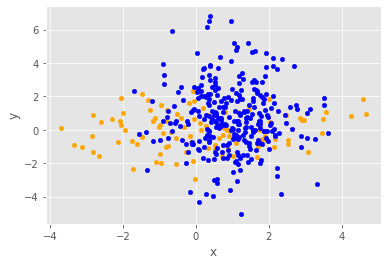

In [17]:
# normal distributions parameters
meanP,sdP = [0,0],[2,1]
meanN,sdN = [1,1],[1,2]
# sample sizes
nP,nN = 100,300
# simulate two samples
dataROC = pd.DataFrame({'x':normal(meanP[0],sdP[0],size=nP),
                        'y':normal(meanP[1],sdP[1],size=nP),'class':'Positive'})
dataROC = dataROC.append(pd.DataFrame({'x':normal(meanN[0],sdN[0],size=nN),
                        'y':normal(meanN[1],sdN[1],size=nN),'class':'Negative'})) 
ax = dataROC[:nP].plot(x='x',y='y',kind='scatter',color="orange")
dataROC[nP:].plot(ax=ax,x='x',y='y',kind='scatter',color="blue")

Package **Scikit-learn** provides tools for calculating Receiver operating characteristic (ROC) and the area under the ROC curve. The function [roc_curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve) computes the curve, and [roc_auc_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score) - the area under the curve.

Getting ROC curve for logistic regression

ROC AUC =  0.6952333333333333


<ipython-input-18-26c7e21eea37>:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([0,1],[0,1],'r--',color='grey')


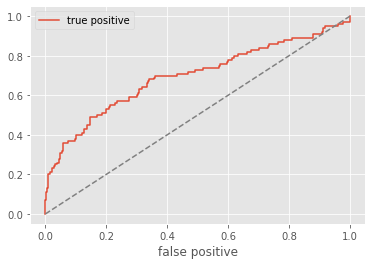

In [18]:
clf = LogisticRegression()
X,y = dataROC[['x','y']],dataROC['class']
clf.fit(X,y)
# get predictions of positive class
preds = clf.predict_proba(X)[:,1]
# roc_curve accept string labels if pos_label is set
fpr, tpr, _ = metrics.roc_curve(y, preds,pos_label='Positive')

pd.DataFrame({'false positive':fpr, 'true positive':tpr}).plot(x='false positive')
# add diagonal dashed line
plt.plot([0,1],[0,1],'r--',color='grey')
# roc_curve does not accept string labels. Conver y to binary
print('ROC AUC = ',metrics.roc_auc_score(y=='Positive', preds))

Note that according the definitions above **Sensitivity** is equal to **True Positive Rate** and **1-Specificity** is equal to **False Positive Rate**.    

Classification performance evaluation for several classes
----------------------

Let $N$ be the number of objects to classify, $M$ - number of classes, let also $y_{ij}$ be 1 if object $i$ belongs to class $j$,  and 0 otherwise.    
Finally, let $p_{ij}$ be predicted probability that object $i$ belongs to class $j$.    
Vector $<p_{i1},p_{i2},.,p_{i,M}>$ is the output of the classification algorithm for object $i$.    
A popular classification performance estimate is **logloss**.    
The formula for logloss is
$$
logloss=-\frac{1}{N}\sum_{i=1}^{N}\sum_{j=1}^{M}y_{ij}\ln (p_{ij}).
$$
For example, let the number of classes be $M=2$ and there is only one object that needs to be classified. Then the logloss formula is
$$
logloss=-y_{11}\ln (p_{11})-y_{12}\ln (p_{12}).
$$
If for this object the correct class is 1 then $y_{11}=1$,  $y_{12}=0$ and $logloss= - \ln (p_{11})$.    
Suppose the ideal case when the classification algorithm returned vector  $<1,0>$. Then $logloss=0$.    
If the algorithm classifies correctly, but assigns more uncertainty to the first class: $<0.7,0.3>$ then the penalty function is $logloss=-\ln (0.7)$ = 0.3567.     
If predicted probability for the first class is small the penalty function can potentially go to infinity. That is why in practice input values $p_{ij}$ are replaced by $\max (C,p_{ij})$, where $C$ is a small positive number.    
For example, if $C=10^{-16}$ an incorrect forecast is a subject to a penalty of 36.84.    

Write function `multiclass_log_loss(y_true, y_pred)` for calculation of logloss using the formula above.    
Argument `y_true` is array of actual class numbers $0 \leq y_i<M,~i=1,\ldots,N$.       
Argument `y_pred` is $N\times M$ matrix of prediction probabilities $p_{ij}$. Each row of this matrix is the vector of probabilities of observation $i$ belonging to class $j$.  

<span style="color:red">(Skipped Code)</span>.

In [19]:
def multiclass_log_loss(y_true, y_pred, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    Parameters
    ----------
    y_true : array, shape = [n_samples]
    y_pred : array, shape = [n_samples, n_classes]

    Returns
    -------
    loss : float
    """
    y_true, y_pred = np.array(y_true),np.array(y_pred)
    predictions = np.clip(y_pred, eps, 1 - eps)
    # in case of array input convert it to matrix with 1 row
    if predictions.ndim==1: predictions = predictions.reshape((1,-1))
    # normalize row sums to 1
    predictions /= predictions.sum(axis=1).reshape((-1,1))

    actual = np.zeros(predictions.shape)
    rows = actual.shape[0]
    actual[np.arange(rows), y_true.astype(int)] = 1
    return -np.sum(actual * np.log(predictions)) / rows

Check the logloss function for the following examples.

In [20]:
y_true, y_pred = [1,4],np.array([[0,1,0,0,0],[0,0,0,0,1.0]])
print(y_pred)
print(multiclass_log_loss(y_true, y_pred))
y_pred[:] = [[0.02,.92,0.02,0.02,0.02],[0.02,0.02,0.02,0.02,.98]]
print(y_pred)
print(multiclass_log_loss(y_true, y_pred))

[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
4.218847493575604e-15
[[0.02 0.92 0.02 0.02 0.02]
 [0.02 0.02 0.02 0.02 0.98]]
0.08092661219027317


Logloss function is included in section metrics of **sklearn** package. Since *y_true* does not contain all class labels in this example we should explicitly specify the set of labels.

In [21]:
metrics.log_loss(y_true, y_pred,labels=range(5))

0.08092661219027317

Check calculation of the function manually:

In [22]:
pr1 = normalize(y_pred,norm='l1',) # normalize rows with function from sklearn.preprocessing
-(np.log(pr1[0,y_true[0]]) + np.log(pr1[1,y_true[1]]))/2

0.08092661219027317

In [23]:
(multiclass_log_loss([y_true[0]], y_pred[0,:]),
 multiclass_log_loss([y_true[1]], y_pred[1,:]))

(0.08338160893905101, 0.07847161544149532)

In [24]:
(multiclass_log_loss([y_true[0]], y_pred[0,:]) + 
                         multiclass_log_loss([y_true[1]], y_pred[1,:]))/2

0.08092661219027317

## Example: Manual implementation of Gini impurity measure

To understand Gini impurity measure create a simple vector containing 2 classes: 

In [25]:
ClassesTest = [0,1,1,0,1]

Create predictor and data frame.

<AxesSubplot:xlabel='PredictorsTest', ylabel='ClassesTest'>

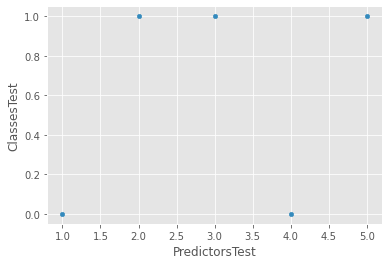

In [26]:
PredictorsTest = [1,2,3,4,5]
TestData = pd.DataFrame({'PredictorsTest':PredictorsTest,
                         'ClassesTest':ClassesTest})
TestData.plot(x='PredictorsTest',y='ClassesTest',kind='scatter')

Run classification tree algorithm.

In [27]:
testTree = DecisionTreeClassifier(random_state=0)
testTree.fit(TestData[['PredictorsTest']],ClassesTest)

DecisionTreeClassifier(random_state=0)

Visualize the tree.

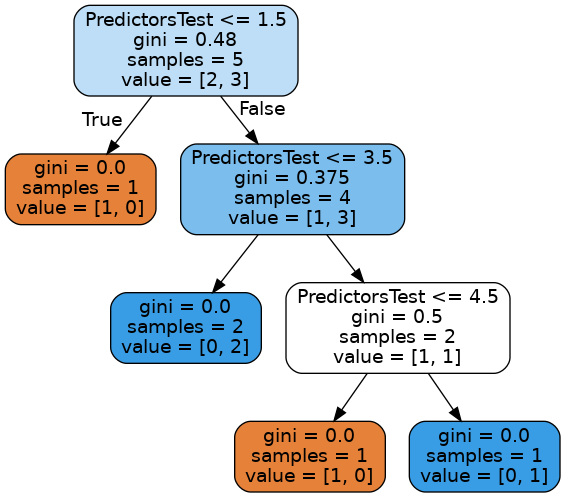

In [28]:
plot_tree(testTree,['PredictorsTest'])

Cells containing only class 0 are orange, class 1 - dark blue. Classes are spread evenly in the white cell.

DecisionTreeClassifier has optional parameter *min_impurity_decrease*.  
A node will be split if this split induces a decrease of the impurity greater than or equal to this value.

Increasing *min_impurity_decrease* level prune the tree.

In [29]:
prunedTree = DecisionTreeClassifier(random_state=0,min_impurity_decrease=0.18)
prunedTree.fit(TestData[['PredictorsTest']],ClassesTest)

DecisionTreeClassifier(min_impurity_decrease=0.18, random_state=0)

Show the tree

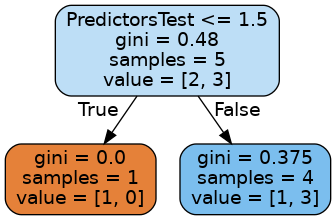

In [30]:
plot_tree(prunedTree,['PredictorsTest'])

Check how Gini impurity measure makes decisions about branching the tree at each step.

Simplify the task by assigning lower values of the predictor to the first class and higher values to the second class.     
**How does that simplify the tree?**

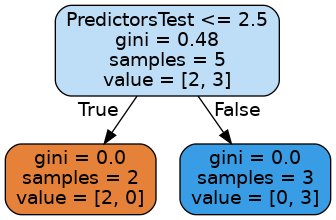

In [31]:
TestData['PredictorsTest'] = [2,5,3,1,4]

testTree = DecisionTreeClassifier(random_state=0)
testTree.fit(TestData[['PredictorsTest']],ClassesTest)
plot_tree(testTree,['PredictorsTest'])

## Example: Mixture model

Create a mixture model of two Gaussian distributions.

In [32]:
seed(0)
n = [600,400]
weight = np.array(n)/sum(n)
mju = [3,4.5]
sigma = [0.4,0.5]
mixModelSample = pd.DataFrame({'x':np.append(normal(loc=mju[0], scale=sigma[0], size=n[0]),
                                             normal(mju[1],sigma[1],n[1])),
                               'Class':np.append(np.zeros(n[0]),np.ones(n[1])).astype(int)})

We will use [seaborn](https://seaborn.pydata.org/) package here.
Seaborn is a Python visualization library based on matplotlib. It provides a high-level interface for drawing attractive statistical graphics. Drawing histogram and density on the same plot with *distplot* function is as easy as

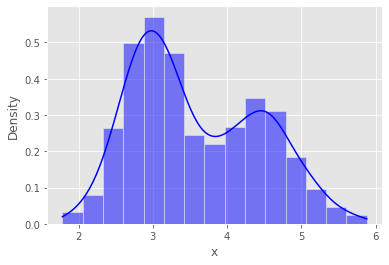

In [33]:
ax = sns.histplot(mixModelSample.x, color="blue", label = 'histogram', 
                  stat = 'density', kde=True)

Reshuffle the rows.

In [34]:
mixModelSample = shuffle(mixModelSample,random_state=0).reset_index(drop=True)

Cluster the sample using function *GaussianMixture* from **sklearn** package.

In [35]:
EstimatedModel = GaussianMixture(n_components=2,covariance_type='spherical',
                                 random_state=0,reg_covar=0.1)
X,y = mixModelSample[['x']],mixModelSample.Class
EstimatedModel.fit(X,y)
est_weights = EstimatedModel.weights_
est_means = EstimatedModel.means_.flatten()
est_sigma = EstimatedModel.covariances_.flatten()
print('weights',est_weights,'\nmeans',est_means,'\nsigma',est_sigma)

weights [0.38461798 0.61538202] 
means [4.36261702 3.09194561] 
sigma [0.53560362 0.39936815]


Add theoretical density and density estimated with Gaussian Mixture model to the above plot.

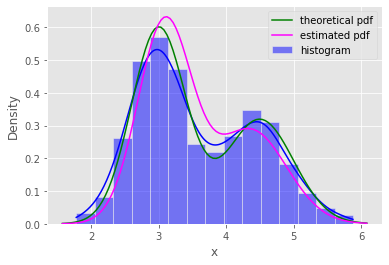

In [36]:
def pdf(x,mju,sigma,weight):
    return sum([norm.pdf(x,loc=mju[i],scale=sigma[i])*weight[i] for i in [0,1]])
t = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(t,pdf(t,mju,sigma,weight),label='theoretical pdf',color='green')
ax.plot(t,pdf(t,est_means,est_sigma,est_weights),label='estimated pdf',
        color='magenta')
ax.legend()
ax.get_figure()

Method *predict* classifies samples, but it does not use labels *y* in classification. So it can easily mark Class 0 with 1 and vice versa. We wil check the positive rate and inverse predic tion if nesessary.

In [37]:
gm_pred = EstimatedModel.predict(X)
gm_pred_prob = EstimatedModel.predict_proba(X)[:,1]
pos_rates = [np.mean(y),np.mean(gm_pred)]
if min(pos_rates)<0.5 and max(pos_rates)>0.5: 
    gm_pred = 1 - gm_pred
    gm_pred_prob = 1 - gm_pred_prob

 Estimate classification accuracy 

In [38]:
print('Accuracy',metrics.accuracy_score(y,gm_pred))
print('ROC_AUC',metrics.roc_auc_score(y,gm_pred_prob))

Accuracy 0.948
ROC_AUC 0.9933958333333334


Now do the same classification using tree.

***Note that `Gaussian Mixture model` did clustering: the method did not use training sample like DecisionTreeClassifier does.***      
***Of course, in exchange `Gaussian Mixture model` knows about the model assumption: normal mixed model.***    

Iterate over *min_impurity_decrease* values in order to find the best one.

0.003 0.958


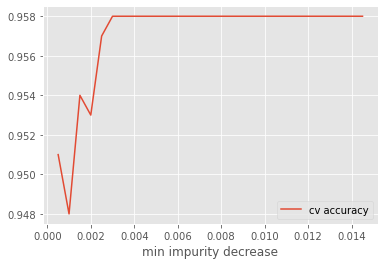

In [39]:
min_impurity_decrease = np.arange(1,30)*0.0005
cv_score = [np.mean(cross_val_score(DecisionTreeClassifier(random_state=0,
    min_impurity_decrease=imp), X, y, cv=10)) for imp in min_impurity_decrease]
plt.plot(min_impurity_decrease,cv_score, label="cv accuracy")
plt.xlabel("min impurity decrease")
plt.legend()
best_imp_dec = min_impurity_decrease[np.argmax(cv_score)]
print(best_imp_dec,max(cv_score))

All values above 0.03 give the same CV accuracy (and most likely the same tree).

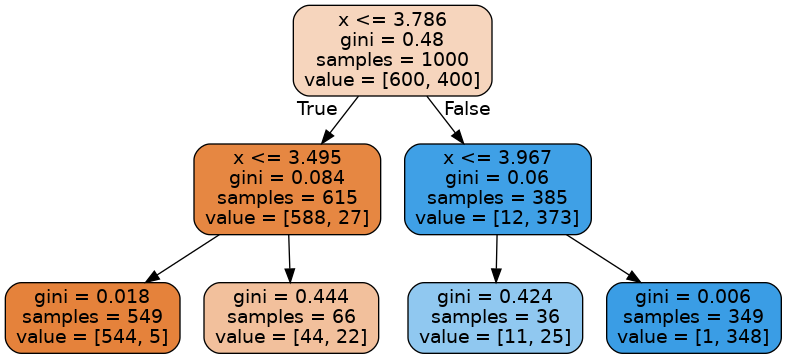

In [40]:
clf = DecisionTreeClassifier(random_state=0,min_impurity_decrease=best_imp_dec)
clf.fit(X,y)
plot_tree(clf,list(X))

Compare tree classification quality with that of `Gaussian Mixture model`.

In [41]:
print('Accuracy',metrics.accuracy_score(y,clf.predict(X)))
print('ROC_AUC',metrics.roc_auc_score(y,clf.predict_proba(X)[:,1]))

Accuracy 0.961
ROC_AUC 0.9886479166666667


## Example: Otto Product Classification    

In this example we will use data set, provided by **Otto Group** for **Kaggle** competition [Otto Group Product Classification Challenge](https://www.kaggle.com/c/otto-group-product-classification-challenge).      

The goal of the project was categorization about 200,000 unspecified products into 9 classes based on 93 unspecified features.    
For simplicity we reduced in this example the number of products and the number of classes.     

### Structure of the Data

Read the data.

In [42]:
Data = pd.read_csv('DTTrain.csv')

Explore the training data set.

In [43]:
# dataset dimensions
print(Data.shape)
# data content
Data.head()

(10233, 95)


,time,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,45652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Class_5
1,225646,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,Class_3
2,345735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,7.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,Class_5
3,436478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Class_5
4,478129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Class_5


Each *column* represents an integer feature.      
Each *row* corresponds to a product.       
The first *column* is the time of information acquisition. The last *column* is the target variable, i.e. the product class. This column is excluded from the test data.

In [44]:
classColName = list(Data)[-1]
Data[classColName][:5]

0    Class_5
1    Class_3
2    Class_5
3    Class_5
4    Class_5
Name: target, dtype: object

The class variable is a character string in the last column called *target*.

Shuffle the rows before the analysis.           
Set seed for reproducibility.

In [45]:
# remove time stamp, shuffle and reset index
xTrain = shuffle(Data.drop('time',axis=1),random_state=0).reset_index(drop=True)
target = xTrain.target
xTrain = xTrain.drop('target',axis=1)
xTrain.shape

(10233, 93)

### Creating and Plotting Small Classification Tree  
In the following call we use one control parameter: `min_samples_leaf` - the minimum number of observations in any terminal (leaf) node.      
Set **min_samples_leaf=500** in order to be able to plot a small tree returned by the function in this case.

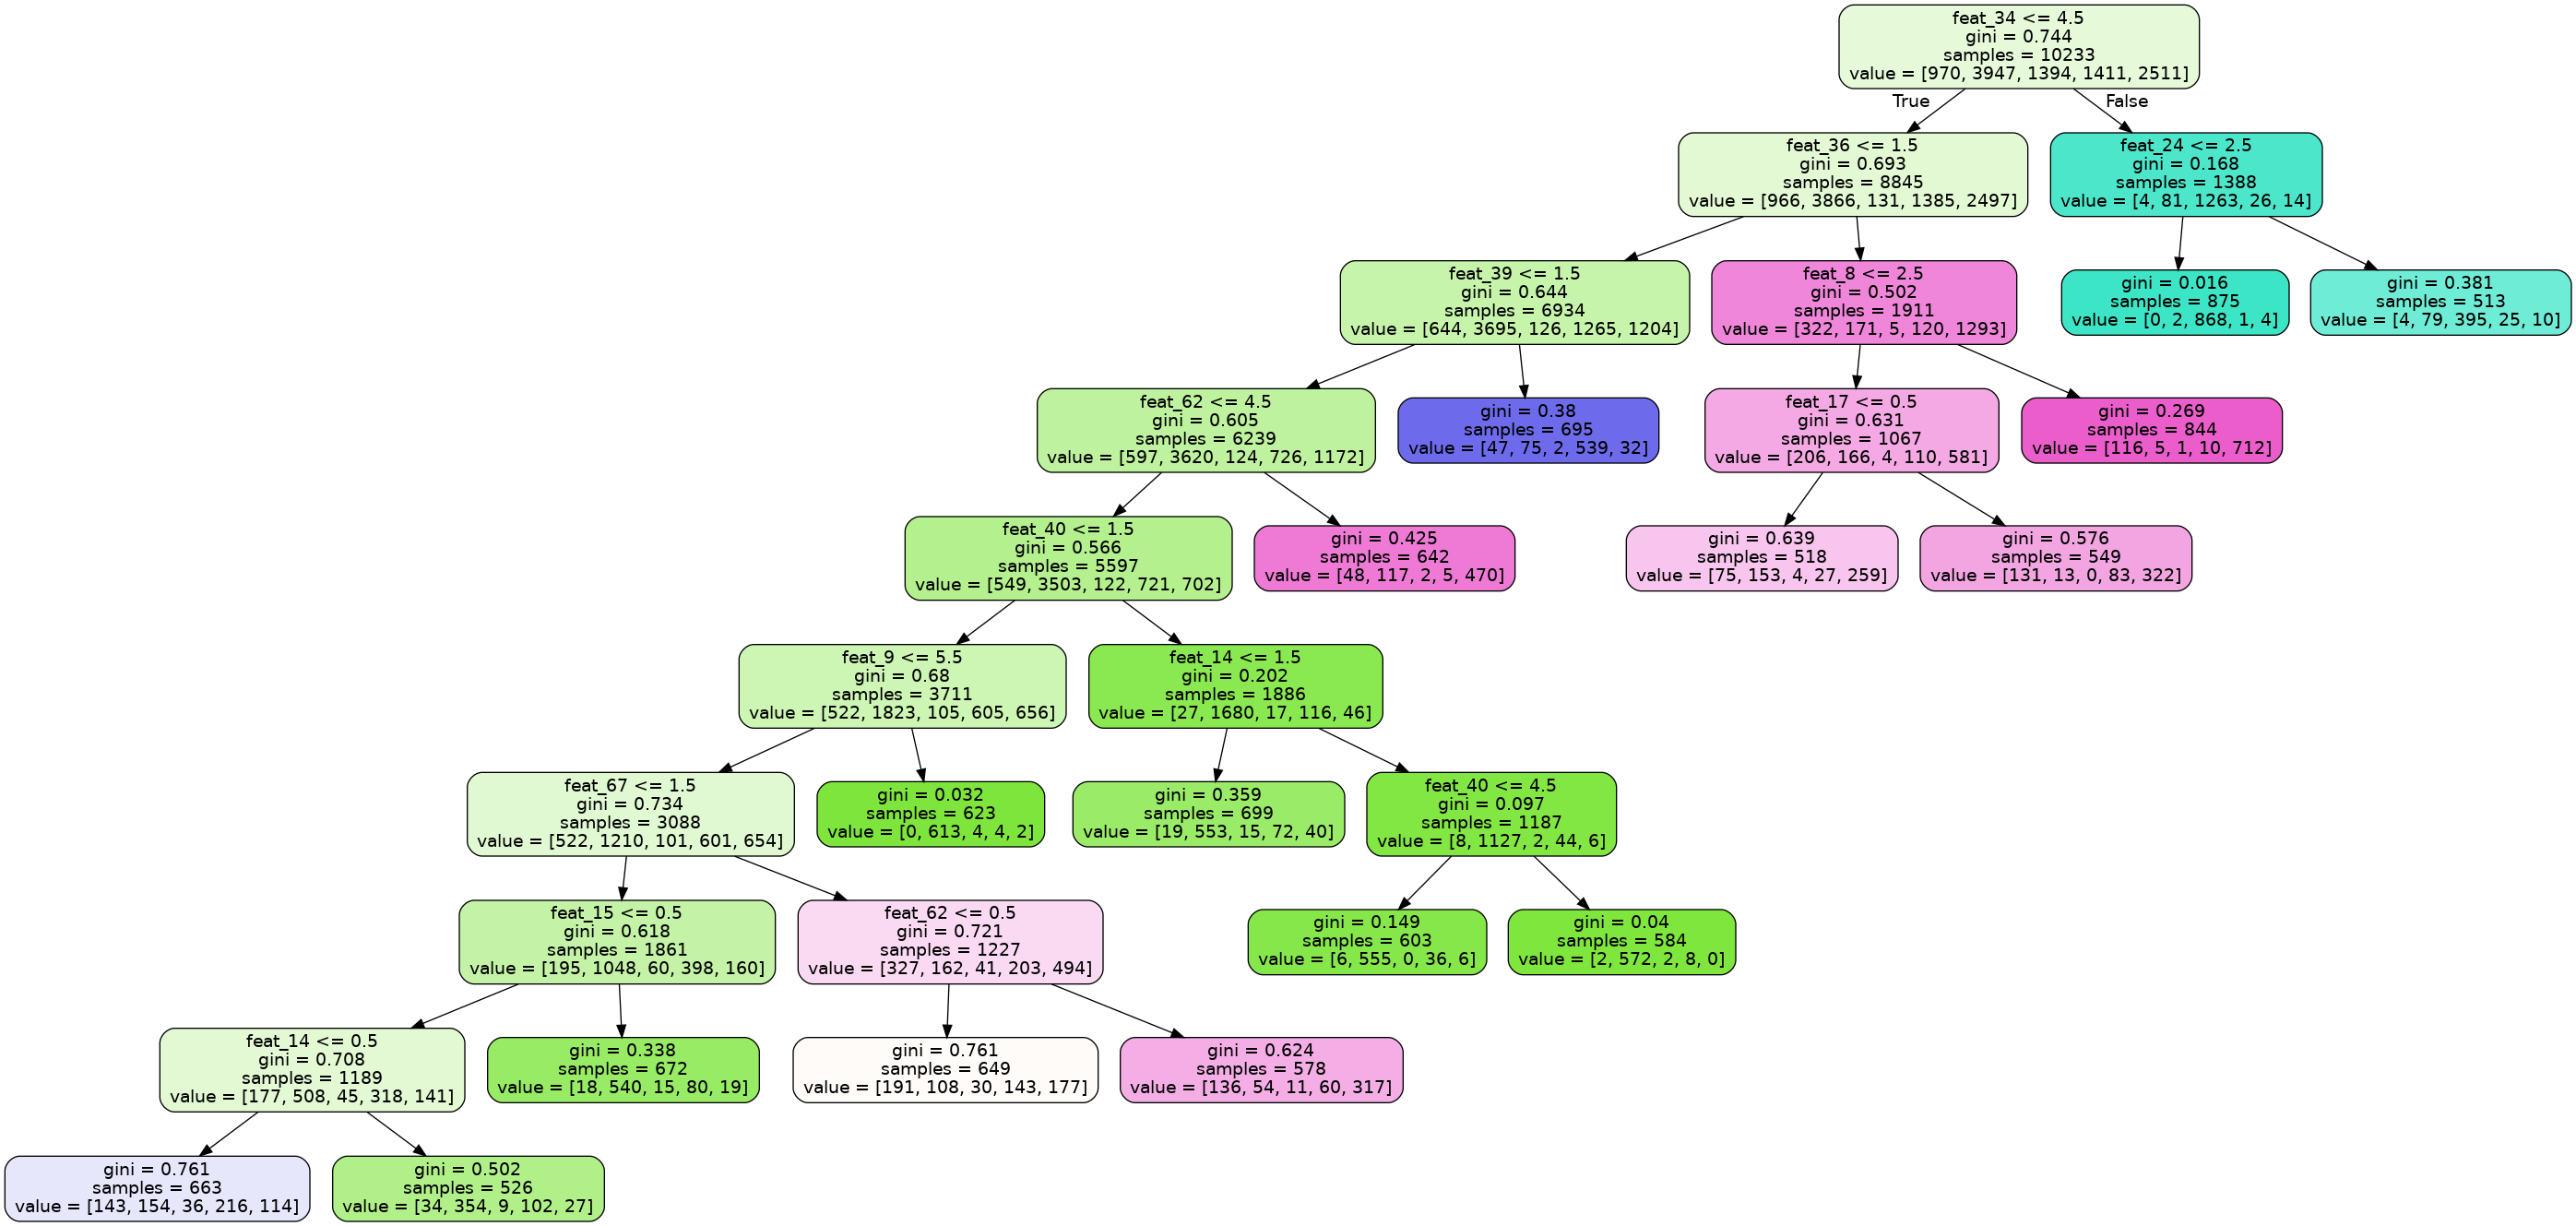

In [46]:
smallTree = DecisionTreeClassifier(random_state=0,min_samples_leaf=500)
smallTree.fit(xTrain,target)
plot_tree(smallTree,list(xTrain))

*Value* numbers in each leaf box display the number of each class samples in this node. The color corresponds to the estimated class number.      

Now predict probabilities that an observation belongs to each class for the first 2 rows of *xTtrain*.     
Select the first 2 rows of *xTtrain* and predict them using *smallTree*.

In [47]:
test = xTrain[:2]
distr = smallTree.predict_proba(test)
distr

array([[0.13744076, 0.00592417, 0.00118483, 0.01184834, 0.8436019 ],
       [0.0676259 , 0.10791367, 0.0028777 , 0.77553957, 0.04604317]])

**Check if the observations were classified correctly**.

In [48]:
pd.DataFrame({'class_pred':smallTree.predict(test),
              'actual':target[:2]})

,class_pred,actual
0,Class_5,Class_5
1,Class_4,Class_4


Calculate log loss penalty function. As we mentioned above the list of labels is to be specifies in this case. 

In [49]:
labels = sorted(set(target))
labels

['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5']

In [50]:
metrics.log_loss(target[:2],distr,labels=labels)

0.2121354289198881

This example shows how "tough" is the logloss measure: even though both classes are classified correctly if decision is made by maximizing probability in the vector of predictions, the measure punishes for lack of confidence.    

See the contribution of each observation

In [51]:
(multiclass_log_loss(labels.index(target[0]),distr[0]),
 multiclass_log_loss(labels.index(target[1]),distr[1]) )

(0.17007458318398128, 0.2541962746557949)

# Trees vs. Linear Models

Compare work of tree model and linear logistic regression model as binary classification methods. 
Logistic regression partitions feature space by one hyper plane.    
Obtained semispaces define the two classes.     
Classification tree algorithm recursively partitions feature space by a hyper planes orthogonal to one of the axes. So, the resulting critical domain can be much more complex than semispace.  

Consider the following two examples.

## Example. Galton's data


Galton's data on the heights of parents and their children can be found in package **HistData**.    
This data set lists the individual observations for 934 children in 205 families on which Galton (1886) based his cross-tabulation.

In [52]:
GaltonFamilies = pd.read_csv('Galton_data.csv')
GaltonFamilies.head()                             

,family,father,mother,midparentHeight,children,childNum,gender,childHeight
0,001,78.5,67.0,75.43,4,1,male,73.2
1,001,78.5,67.0,75.43,4,2,female,69.2
2,001,78.5,67.0,75.43,4,3,female,69.0
3,001,78.5,67.0,75.43,4,4,female,69.0
4,002,75.5,66.5,73.66,4,1,male,73.5


Here are basic statistics.

In [53]:
GaltonFamilies.describe()

,father,mother,midparentHeight,children,childNum,childHeight
count,934.000000,934.000000,934.000000,934.000000,934.000000,934.000000
mean,69.197109,64.089293,69.206773,6.171306,3.585653,66.745931
std,2.476479,2.290886,1.802370,2.729025,2.361410,3.579251
min,62.000000,58.000000,64.400000,1.000000,1.000000,56.000000
25%,68.000000,63.000000,68.140000,4.000000,2.000000,64.000000
50%,69.000000,64.000000,69.248000,6.000000,3.000000,66.500000
75%,71.000000,65.875000,70.140000,8.000000,5.000000,69.700000
max,78.500000,70.500000,75.430000,15.000000,15.000000,79.000000


Families are largely listed in descending order of fathers and mothers height.   

Reshuffle them to ensure correct cross validation procedure.

In [54]:
GaltonFamilies = shuffle(GaltonFamilies,random_state=0
                                        ).reset_index(drop=True)

Note that mid-parent height is calculated as  
$$midparentHeight = \frac{1}{2}(father + 1.08 \times mother)$$  
The goal is to identify each child gender by her or his height and mid-parent height.    
Look at the data scatterplot.

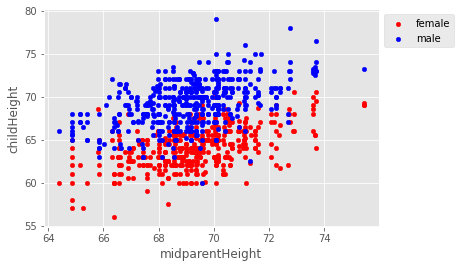

In [55]:
gender = GaltonFamilies.gender == "female"
ax = GaltonFamilies[gender].plot(x='midparentHeight',y='childHeight',
                                 kind='scatter',color='red')
GaltonFamilies[~gender].plot(ax=ax,x='midparentHeight',y='childHeight',
                             kind='scatter',color="blue")
ax.legend(['female','male'],bbox_to_anchor=(1, 1))

Apply Logistic Regression to the data. Class *LogisticRegression* implements regularized logistic regression. It is controlled by positive float parameter *C*, inverse of regularization strength. Smaller values specify stronger regularization. Set large *C* in order to compare results with those obtained in  R version.

In [56]:
clf = LogisticRegression(C = 1e9)
X,y = GaltonFamilies[['midparentHeight','childHeight']],gender
clf.fit(X,y)
beta = np.append(clf.intercept_,clf.coef_) 
beta

array([18.76533816,  0.76688898, -1.08027964])

The equation of the line, separating target classes is
$$f(x)=-(\beta _{0}+\beta _{1}x)/\beta _{2}$$

Draw it on the plot above.

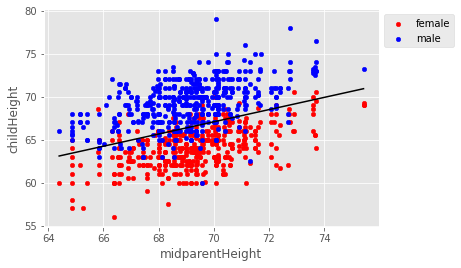

In [57]:
x_range = np.array([min(GaltonFamilies.midparentHeight),
                    max(GaltonFamilies.midparentHeight)])
ax.plot(x_range,-(beta[0]+x_range*beta[1])/beta[2], color='black')
ax.get_figure()

We see that in spite of high noise level straight line successfully separates male and female items.     

Let us check the predictive quality of the method with 10-fold cross validation implemented in the **sklearn** package.

In [58]:
lr_score = cross_val_score(clf, X, y, cv=10)
print('Accuracy: mean =',np.mean(lr_score),',  standard deviation = ',
      np.std(lr_score))

Accuracy: mean = 0.8865248226950355 ,  standard deviation =  0.026685910974230495


Now classify the data using *DecisionTreeClassifier*. Find the optimal value of parameter *min_impurity_decrease*.

0.0025 0.8865362617250057


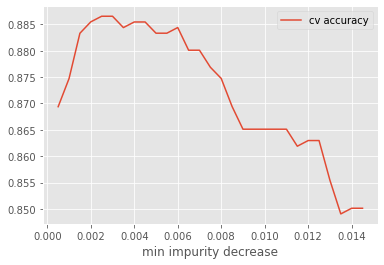

In [59]:
min_impurity_decrease = np.arange(1,30)*0.0005
cv_score = [np.mean(cross_val_score(DecisionTreeClassifier(random_state=0,
    min_impurity_decrease=imp), X, y, cv=10)) for imp in min_impurity_decrease]
plt.plot(min_impurity_decrease,cv_score, label="cv accuracy")
plt.xlabel("min impurity decrease")
plt.legend()
best_imp_dec = min_impurity_decrease[np.argmax(cv_score)]
print(best_imp_dec,max(cv_score))

The plot shows no improvement after parameter value 0.0025. Draw the tree with this optimal value.

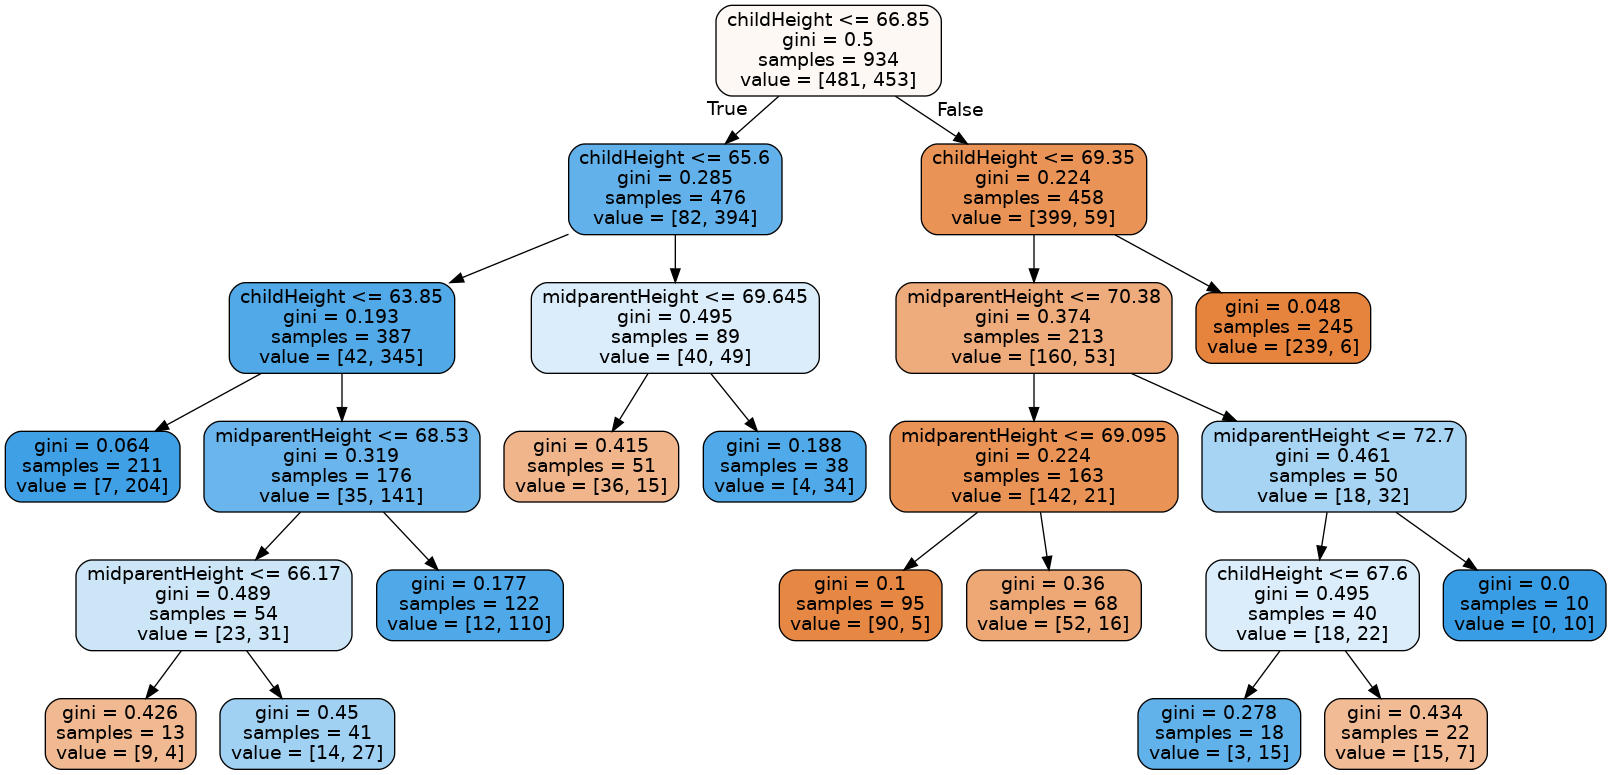

In [60]:
clf = DecisionTreeClassifier(random_state=0,min_impurity_decrease=best_imp_dec)
clf.fit(X,y)
plot_tree(clf,list(X))

As an example of how tree partition splits space draw the domains correspondent to the leftmost and rightmost dark blue leaves. The first leaf includes 7 samples from Class 0 and 204 form Class 1, the second one consists with 10 samples from Class 1.

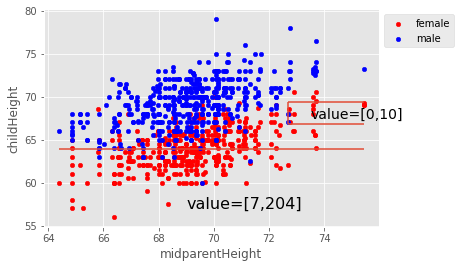

In [61]:
# remove regression line
ax.lines = []
ax.hlines(y=63.85,xmin=x_range[0],xmax=x_range[1])
ax.text(69,57,'value=[7,204]',fontsize=16)
ax.hlines(y=66.85,xmin=72.7,xmax=x_range[1])
ax.hlines(y=69.35,xmin=72.7,xmax=x_range[1])
ax.vlines(x=72.7,ymin=66.85,ymax=69.35)
ax.text(73.5,67.5,'value=[0,10]',fontsize=14)
ax.get_figure()

Finally test tree prediction quality and compare it with the one displayed by logistic regression.

In [62]:
print('Tree regression accuracy',max(cv_score))
print('Logistic regression accuracy',np.mean(lr_score))

Tree regression accuracy 0.8865362617250057
Logistic regression accuracy 0.8865248226950355


Cross validation accuracy of classifiers is similar but tree model has much more parameters. Each split requires two parametesr: feature nimber and threshold. That's why one would prefer linear model in this case. The main reason is that trapezoid, generated by logistic regression is a good approximation for the shapes of both target classes.

## Example. Rectangular class domain

Simulate the data with rectangular shapes of classes.    
Each observation is three-dimensional vector with two numeric features and one categorical (type) with possible values 'Positive' or 'Negative'.     
The goal is to identify type on the basis of first two features.

In [63]:
N = 1000
xPos = 0.2
yMinPos = 0.2
yMaxPos = 0.7
seed(0)
newData = pd.DataFrame({'x':random(N),'y':random(N)})
newData['type'] = newData.apply(lambda s: 'Positive' if s['x']>xPos and s['y']>yMinPos 
                                and s['y']<yMaxPos else 'Negative',axis=1)

Add some noise giving random labels to 10% of the data.

In [64]:
n = N//10
newData.loc[choice(N,n,replace=False),
            'type'] = np.array(['Positive','Negative'])[binomial(1,0.5,n)]

Plot the data

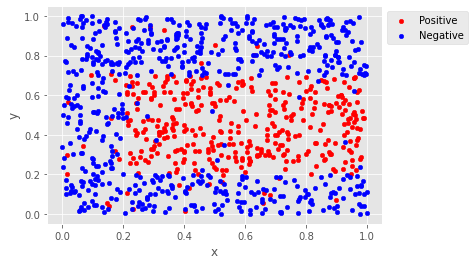

In [65]:
Type = newData['type'] == 'Positive'
ax = newData[Type].plot(x='x',y='y',kind='scatter',color='red')
newData[~Type].plot(ax=ax,x='x',y='y',kind='scatter',color="blue")
ax.legend(['Positive','Negative'],bbox_to_anchor=(1, 1))

Using cross validation compare prediction accuracy of logistic regression and tree regression model with tree depth = 3.

<span style="color:red">(Skipped Code)</span>

In [66]:
clf = LogisticRegression(C = 1e9)
X,y = newData[['x','y']],Type
lr_score = cross_val_score(clf, X, y, cv=10)
print('Logistic regression')
print('Accuracy: mean =',np.mean(lr_score),',  standard deviation = ',
      np.std(lr_score))
tree_clf = DecisionTreeClassifier(random_state=0,max_depth=3)
tree_score = cross_val_score(tree_clf, X, y, cv=10)
print('Decision Tree Classifier')
print('Accuracy: mean =',np.mean(tree_score),',  standard deviation = ',
      np.std(tree_score))

Logistic regression
Accuracy: mean = 0.6130000000000001 ,  standard deviation =  0.037960505792204606
Decision Tree Classifier
Accuracy: mean = 0.9469999999999998 ,  standard deviation =  0.016763054614240186


Rectangular shape of the Positive class domain surrounded by the opposite class points, apparently gives significant advantage to tree classification over linear method.